In [1]:
#https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-HATN/
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn import metrics


#my module
import encode
import _model_

import word_embedding
embedding_matrix = None

Using TensorFlow backend.


#### dataset
dataset from kaggle https://www.kaggle.com/c/word2vec-nlp-tutorial/data
(data was tokenized already on my own)

In [2]:
def read_file(path_file):
    print("read path: ",path_file)
    df= pd.read_csv(path_file, index_col=0)
    return df

path_read_file= 'data/labeledTraintoken.csv'

df= read_file(path_read_file)  
#df= df[:5000]
df.tail()

read path:  data/labeledTraintoken.csv


,id,sentiment,review
24995,3453_3,0,It like consideration IMDb review film review ...
24996,5064_1,0,I believe make film Completely unnecessary The...
24997,10905_3,0,Guy loser girl need build pick strong successf...
24998,10194_3,0,This minute documentary Buñuel make early Spai...
24999,8478_8,1,I movie child break heart No story unfinished ...


#### parameters setting

In [3]:
max_review_length = 500

#### data preprocessing
1. encode: token, encoding number from string with vocabulary
2. padding as the same length 

In [4]:
def preprocessing(df, max_review_length):
    rate_train_test_split= 0.3
    
    x, y, map_vocabulary = encode.encode_data(df) 
    vocabulary= map_vocabulary.values()
    vocabulary_size= len(vocabulary)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= rate_train_test_split, random_state=0)
    print( len(X_train), len(y_train), vocabulary_size )

    #truncate and pad input sequences
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
    
    return X_train, X_test, y_train, y_test, x, y, vocabulary, vocabulary_size

X_train, X_test, y_train, y_test, x, y, vocabulary, vocabulary_size = preprocessing(df, max_review_length)

/Volumes/passport/personal/520/final project/sentiment-analysis-master/encode.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_text = [s.split(" ") for s in df['review'].as_matrix()]
/Volumes/passport/personal/520/final project/sentiment-analysis-master/encode.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y=df['sentiment'].as_matrix()


20000 20000 73290


#### word embedding

In [5]:
if not embedding_matrix:
    embedding_matrix= word_embedding.google_news(vocabulary)    

word embedding...
(73290, 300)
word embedding loading done


In [6]:
def accuracy_curve(h):
    print(h.history.keys())

    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def evaluate_model(model, X_test, y_true):
    scores = model.evaluate(X_test, y_true, verbose=0)

    y_prob = model.predict(X_test, batch_size=10, verbose=1)
    y_pred= [y[0]> 0.5 for y in y_prob]
    precision, recall, fscore, _= precision_recall_fscore_support(y_true, y_pred, average='binary')
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("precision: %.2f%%" % (precision*100))
    print("recall: %.2f%%" % (recall*100))
    print("fscore: %.2f%%" % (fscore*100))

    fpr, tpr, _ = metrics.roc_curve(y_true,  y_prob)
    auc = metrics.roc_auc_score(y_true, y_prob)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [7]:
def train_model(model, X_train, X_test, y_train, y_test, epochs=3, batch_size=32):
    h= model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    print(h.history.keys())
    #dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

    accuracy_curve(h)
    evaluate_model(model, X_test, y_test)


#### training CNN
max_review_length = 100:  epochs= 6
max_review_length = 500:  epochs= 5

/Volumes/passport/personal/520/final project/sentiment-analysis-master/_model_.py:34: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=2, strides=1, padding="valid")`
  subsample_length=1)(graph_in)
/Volumes/passport/personal/520/final project/sentiment-analysis-master/_model_.py:35: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  pool = MaxPooling1D(pool_length=2)(conv)
/Volumes/passport/personal/520/final project/sentiment-analysis-master/_model_.py:34: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3, strides=1, padding="valid")`
  subsample_length=1)(graph_in)
/Volumes/passport/personal/520/final project/sentiment-analysis-master/_model_.py:34: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4, strides=1, padding="valid")`
  subsample_length=1)(graph

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          21987000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
model_2 (Model)              (None, 95488)             345984    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                4774450   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

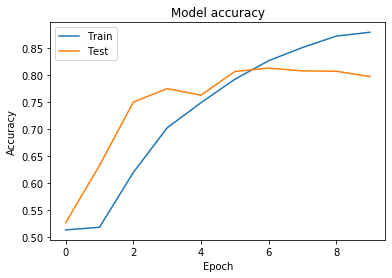

5000/5000 [==============================] - 14s 3ms/step
Accuracy: 79.70%
precision: 87.72%
recall: 68.15%
fscore: 76.70%


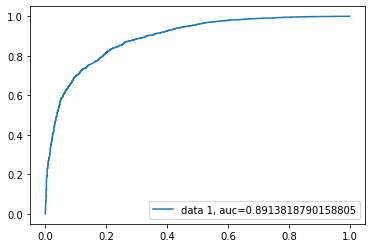

In [10]:
epochs= 10 #5
batch_size=64    
model= _model_.cnn(vocabulary_size, max_review_length, embedding_matrix)
train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size)

#### training LSTM
max_review_length = 100:  epochs= 5
max_review_length = 500:  epochs= 14

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 300)          21987000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 22,308,001
Trainable params: 321,001
Non-trainable params: 21,987,000
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/14
20000/20000 [==============================] - 230s 11ms/step - loss: 0.6244 - accuracy: 0.6456 - val_loss: 0.5741 - val_accuracy: 0.7084
Epoch 2/14
20000/20000 [==============================] - 227s 11ms/step - loss: 0.5612 - accuracy: 0.7139 - val_loss: 0.5061 - val_accuracy: 0.7512
Epoch 3/14
200

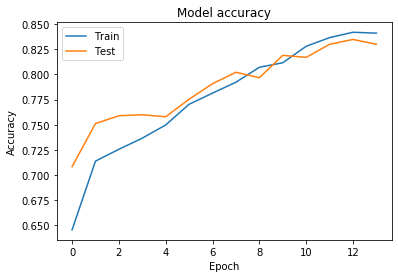

5000/5000 [==============================] - 38s 8ms/step
Accuracy: 83.00%
precision: 82.83%
recall: 82.42%
fscore: 82.62%


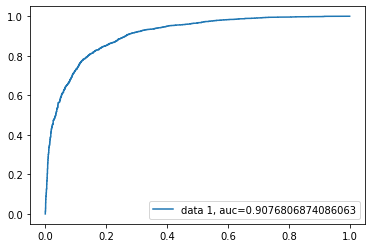

In [9]:
epochs= 14 #14
batch_size=64    
model= _model_.lstm(vocabulary_size, max_review_length, embedding_matrix)
train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size)